In [14]:
import requests
from bs4 import BeautifulSoup as soup
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import csv
import pandas as pd

In [15]:
inicio, hoje = datetime(2020, 5, 19), datetime.today().date()
intervalo = pd.date_range(inicio, hoje)

datas = list()
dose1 = list()
dose2 = list()
conf = list()
ativ = list()
obt = list()

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
                         '(KHTML, like Gecko) Chrome/86.0.4240.111 Safari/537.36 Edg/86.0.622.51'}
url = 'https://muriae.mg.gov.br/coronavirus/'

request = requests.get(url, headers=headers)
page_soup = soup(request.content, 'html.parser')

conteudo = page_soup.body.div.text.split()

chaves = ['Epidemiológico']

for n, palavra in enumerate(conteudo):
    if palavra == 'Epidemiológico':
        string = conteudo[n + 2][0:10]
        d_type = datetime.strptime(string, '%d/%m/%Y')
        datas.append(d_type)
        conteudo.pop(n)
    elif palavra == 'Epidemiológico-':
        string = conteudo[n + 1][0:10]
        d_type = datetime.strptime(string, '%d/%m/%Y')
        datas.append(d_type)
        conteudo.pop(n)
    elif ('Boletim' in conteudo[n] and conteudo[n + 1] == '-') \
    or (conteudo[n] == 'Covid' and conteudo[n+1] == '-'):
        string = conteudo[n + 2][0:5:] + '/2021'
        d_type = datetime.strptime(string, '%d/%m/%Y')
        datas.append(d_type)
        conteudo.pop(n)
    elif (palavra == 'confirmados:') or (palavra == 'covid-19:'):
        inteiro = int(conteudo[n + 1].replace('.', ''))
        conf.append(inteiro)
        conteudo.pop(n)
    elif palavra == 'ativos:':
        ativ.append(int(conteudo[n + 1].replace('Pacientes', '')))
        conteudo.pop(n)
    elif 'Óbitos:' in palavra:
        obt.append(int(conteudo[n + 1].replace('Investigados', '')))
        conteudo.pop(n)
    elif ('Primeira' in conteudo[n] and conteudo[n+1] == 'dose:') or \
                        (conteudo[n] == 'uma' and conteudo[n+1] == 'dose:') or \
                        ( 'uma' in conteudo[n] and conteudo[n+1] == 'dose):') or \
                        ('Parcialmente' in conteudo[n] and conteudo[n+1] == 'vacinados:'):
        dose1.append(int(conteudo[n + 2].replace('Vacinados', '').replace('.', '')))
        conteudo.pop(n)
    elif palavra == 'doses:' or palavra == 'única:' or palavra == 'única):':
        dose2.append(int(conteudo[n + 1].replace('PACIENTESTotal', '').replace('.', '')))
        conteudo.pop(n)
    elif 'Segunda' in conteudo[n] and conteudo[n+1] == 'dose:' or \
                ( 'Totalmente' in conteudo[n] and conteudo[n+1] == 'vacinados:'):
        dose2.append(int(conteudo[n+2].replace('.','')))
        conteudo.pop(n)
    else:
        pass

print(len(datas), len(dose1), len(dose2), len(conf), len(ativ), len(obt))

28 28 28 28 28 28


In [16]:
bkup = pd.read_csv('covid-muriae-auto.csv', sep=';', encoding='Latin1')

bkup['Data'] = [datetime.strptime(data, '%d/%m/%Y') for data in bkup['Data']]
d = {'Data': datas, 'Dose 1': dose1, 'Dose 2': dose2,
     'Casos Totais': conf, 'Casos Ativos': ativ, 'Óbitos': obt}
df = pd.DataFrame(data=d)
df = pd.concat([bkup, df], axis=0)

In [26]:
pd.set_option('display.max_rows', len(df))

d2 = {'Data': intervalo}
df2 = pd.DataFrame(data=d2)
pd.set_option('display.max_rows', len(df2))

joined = pd.merge(df2, df, on='Data', how='left').fillna(0)

joined[['Dose 1', 'Dose 2', 'Casos Totais', 'Casos Ativos', 'Óbitos']] = \
    joined[['Dose 1', 'Dose 2', 'Casos Totais', 'Casos Ativos', 'Óbitos']].astype('int')

# transformando os dados zeros em dados do dia anterior

c = 1
nao_zero = int()
while True:

    for i, value in enumerate(joined.iloc[:, c]):
        if value != 0:
            nao_zero = value
        else:
            if joined.loc[i, joined.columns[0]] != hoje:
                joined.loc[i, joined.columns[c]] = nao_zero
            else:
                joined.drop(i, inplace=True)
    else:
        c += 1
        nao_zero = int()
        if c == len(joined.columns):
            break

joined.at[456, 'Óbitos'] = 301


joined['Casos Diários'] = joined['Casos Totais'].diff().fillna(0).astype('int')
joined['Óbitos Diários'] = joined['Óbitos'].diff().fillna(0).astype('int')

pd.set_option('display.max_columns', len(joined.columns))

pd.set_option('display.max_rows', len(joined))
joined.tail()

,Data,Dose 1,Dose 2,Casos Totais,Casos Ativos,Óbitos,Casos Diários,Óbitos Diários
515,2021-10-16,84022,56368,11858,13,315,0,0
516,2021-10-17,84022,56368,11858,13,315,0,0
517,2021-10-18,84049,56486,11859,6,315,1,0
518,2021-10-19,84059,56910,11860,6,316,1,1
519,2021-10-20,84131,57483,11860,4,316,0,0


In [27]:
def plotar_casosVSimun(save=False, show=True):
    from numpy import max
    plt.figure(figsize=(1080 / 600, 1080 / 600), dpi=600)
    ax = plt.axes()
    ax.set(facecolor='#c6e2ff')
    plt.plot(joined['Data'], joined['Dose 1'], color='#8dae56', linewidth=0.5, label='Dose 1 da Vacina')
    plt.plot(joined['Data'], joined['Dose 2'], color='green', linewidth=0.5, label='Dose 2 e dose única da Vacina')
    plt.subplots_adjust(top=0.86, bottom=0.1, left=0.15, right=0.96)
    plt.xticks(joined['Data'][::60], fontsize=2, rotation=20, y=0.04)
    plt.xlim(min(joined['Data']), max(joined['Data']))
    plt.ylim(0, max(joined['Dose 1'] + 16000))
    plt.yticks(range(0, max(dose1), 6000), fontsize=3, x=0.03)
    plt.ylabel('Doses', fontsize=2, labelpad=0.8)
    plt.legend(loc='upper right', fontsize=2)
    
    ax2 = plt.gca().twinx()
    plt.ylabel('Casos Ativos', fontsize=2, labelpad=0.8)
    plt.yticks(fontsize=2)
    plt.xlim(min(joined['Data']), max(joined['Data']) + timedelta(days=1))
    plt.ylim(0, max(joined['Casos Ativos'] + 20))
    plt.plot(joined['Data'], joined['Casos Ativos'], color='orange', linewidth=0.5)
    plt.title('Casos Ativos vs Doses aplicadas em Muriaé \n'
              'segundo os boletins epidemiológicos da \n'
              'Prefeitura de Muriaé', fontsize=2.5, y=0.96)
    plt.tight_layout()
    if save:
        
        plt.savefig('C:/Users/GCPeppe/Pictures/ativos-vs-imunizados.png')
        
    else:
        pass

    if show:
        plt.show()
    else:
        pass


def plotar_casosAtivos(save=False, show=True):
    from numpy import max, min

    plt.figure(figsize=(1080 / 600, 1080 / 600), dpi=600)
    ax = plt.axes()
    ax.set(facecolor='#c6e2ff')
    plt.plot(joined['Data'], joined['Casos Ativos'], color='orange', linewidth=0.5)
    plt.xlim(min(joined['Data']), max(joined['Data']) + timedelta(days=1))
    plt.subplots_adjust(top=0.86, bottom=0.1, left=0.15, right=0.96)
    plt.yticks(range(0, max(joined['Casos Ativos']), 45), fontsize=3, x=0.03)
    plt.xticks(joined['Data'][::60], fontsize=2.5, rotation=20, y=0.04)
    plt.ylabel('Casos Ativos', fontsize=6, labelpad=0.47)
    plt.title(
        'Evolução dos Casos Ativos de COVID-19 em Muriaé \n '
        'segundo os boletins epidemiológicos \n da '
        'Prefeitura de Muriaé', fontsize=4, y=0.96
    )

    if save:
        plt.savefig('C:/Users/GCPeppe/Pictures/casos_ativos.png', dpi=600)
    else:
        pass

    if show:
        plt.show()
    else:
        pass


def plotar_obitos(save=False, show=True):
    from numpy import max

    plt.figure(figsize=(1080 / 600, 1080 / 600), dpi=600)
    ax = plt.axes()
    ax.set(facecolor='#c6e2ff')
    plt.bar(joined['Data'], joined['Óbitos Diários'], color='red', width=1)
    plt.subplots_adjust(top=0.86, bottom=0.1, left=0.15, right=0.96)
    plt.yticks(range(0, max(joined['Óbitos Diários']) + 1), fontsize=3, x=0.02)
    plt.xlim(min(joined['Data']), max(joined['Data']) + timedelta(days=1))
    plt.xticks(joined['Data'][::90], fontsize=2.5, rotation=20, y=0.04)
    plt.ylabel('Óbitos Diários', fontsize=6, labelpad=0.48)
    plt.title(
        'Óbitos diários por COVID-19 em Muriaé \n '
        'segundo os boletins epidemiológicos \n '
        'da Prefeitura de Muriaé', fontsize=4, y=0.96
    )

    if save:
        plt.savefig('C:/Users/GCPeppe/Pictures/covid_obitos.png', dpi=600)
    else:
        pass

    if show:
        plt.show()
    else:
        pass


def plotar_casos_diarios(save=False, show=True):
    from numpy import max

    plt.figure(figsize=(1080 / 600, 1080 / 600), dpi=600)
    ax = plt.axes()
    ax.set(facecolor='#c6e2ff')
    plt.bar(joined['Data'], joined['Casos Diários'], color='blue')
    plt.subplots_adjust(top=0.86, bottom=0.1, left=0.15, right=0.96)
    plt.yticks(range(0, max(joined['Casos Diários']), 20), fontsize=3, x=0.02)
    plt.xticks(joined['Data'][::60], fontsize=2.5, rotation=20, y=0.04)
    plt.xlim(min(joined['Data']), max(joined['Data']) + timedelta(days=1))
    plt.ylabel('Casos Diários', fontsize=6, labelpad=0.48)
    plt.title(
        'Casos Diários de COVID-19 em Muriaé \n '
        'segundo os boletins epidemiológicos \n da '
        'Prefeitura de Muriaé', fontsize=4, y=0.96
    )

    if save:
        plt.savefig('C:/Users/GCPeppe/Pictures/casos_diarios.png', dpi=600)
    else:
        pass

    if show:
        plt.show()
    else:
        pass

def relacao_ativosObtos(save=False, show=True):
    plt.figure(figsize=(12,12))
    ax = plt.axes()
    ax.set(facecolor='#c6e2ff')
    plt.bar(joined['Data'], joined['Óbitos Diários'], color='red')
    plt.ylabel('Óbitos diários', fontsize=16)
    plt.yticks(fontsize=14)
    ax2 = plt.gca().twinx()
    plt.ylabel('Casos Ativos', fontsize=16)
    plt.yticks(fontsize=14)
    plt.xlim(min(joined['Data']), max(joined['Data']) + timedelta(days=1))
    plt.plot(joined['Data'], joined['Casos Ativos'], color='blue')

    if save:
        plt.savefig('C:/Users/GCPeppe/Pictures/casos_obitos.png')
    else:
        pass

    if show:
        plt.show()
    else:
        pass
    

In [19]:
joined.to_csv('covid-muriae-auto.csv', encoding='utf-8', sep=';')

In [20]:
plt.rcParams.update({'figure.facecolor': '#92b69e'})
plt.rcParams['axes.linewidth'] = 0.1

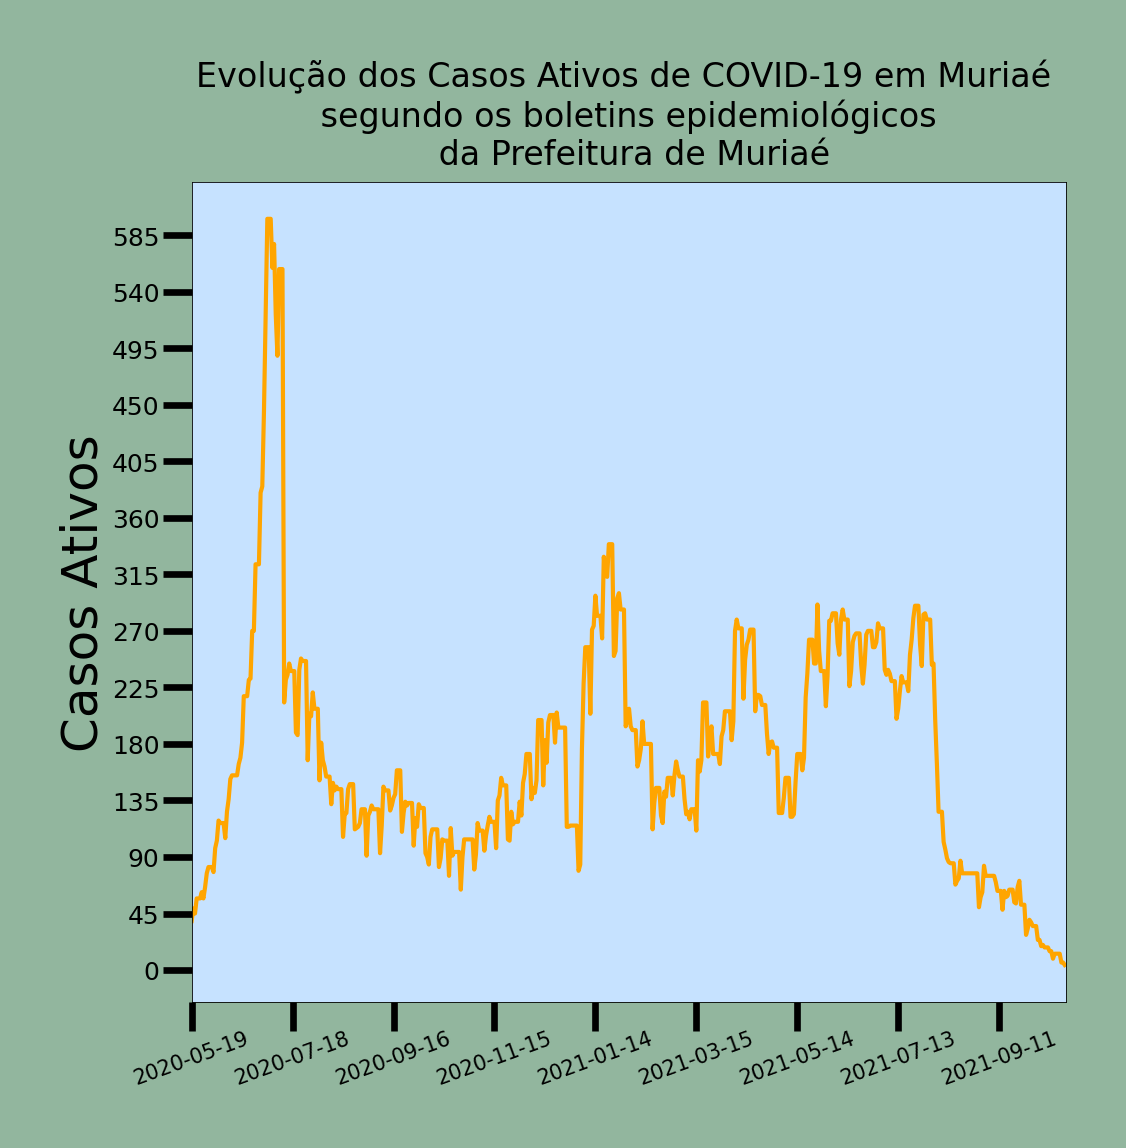

In [28]:
plotar_casosAtivos(save=True)

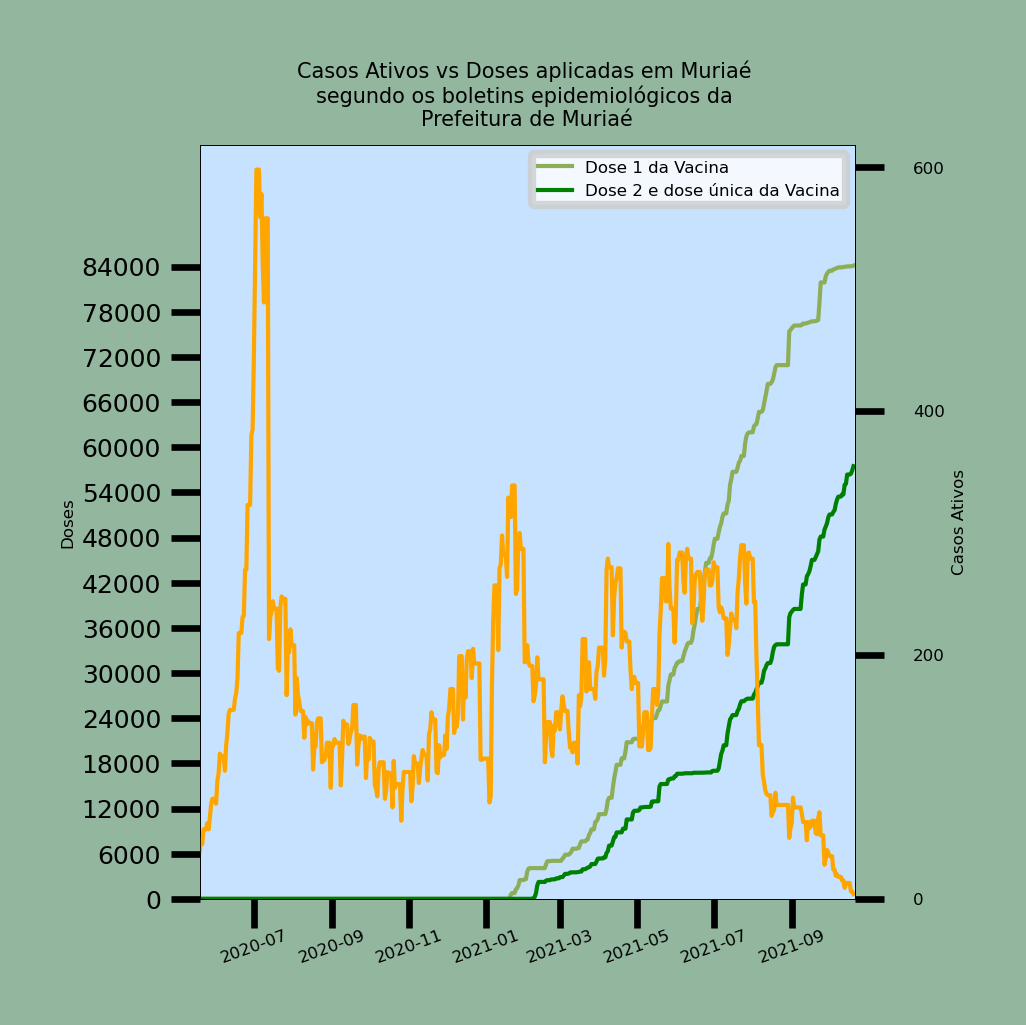

In [29]:
plotar_casosVSimun(save=True)

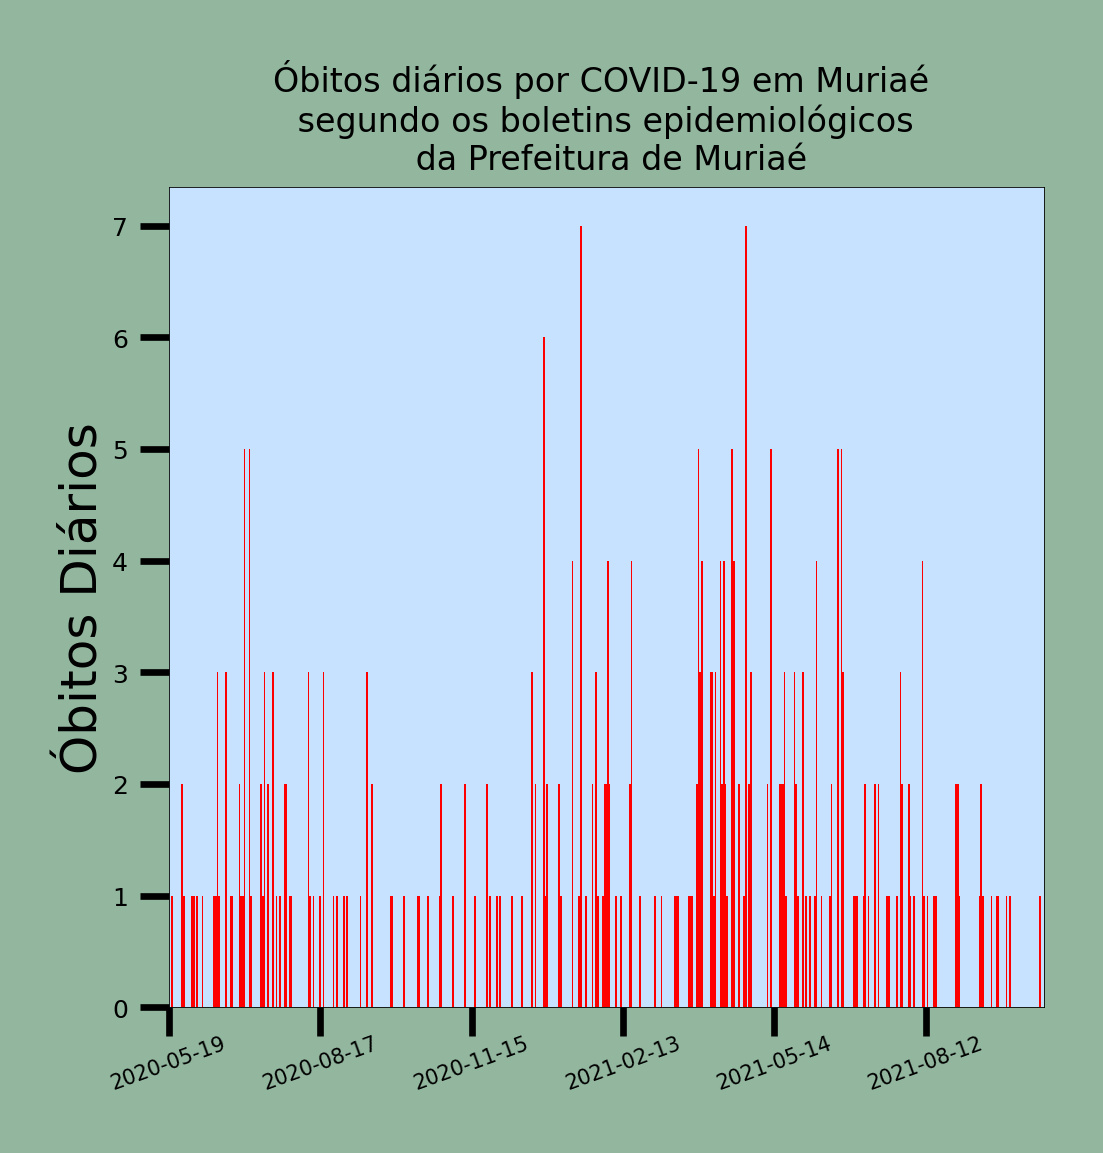

In [30]:
plotar_obitos(save=True)

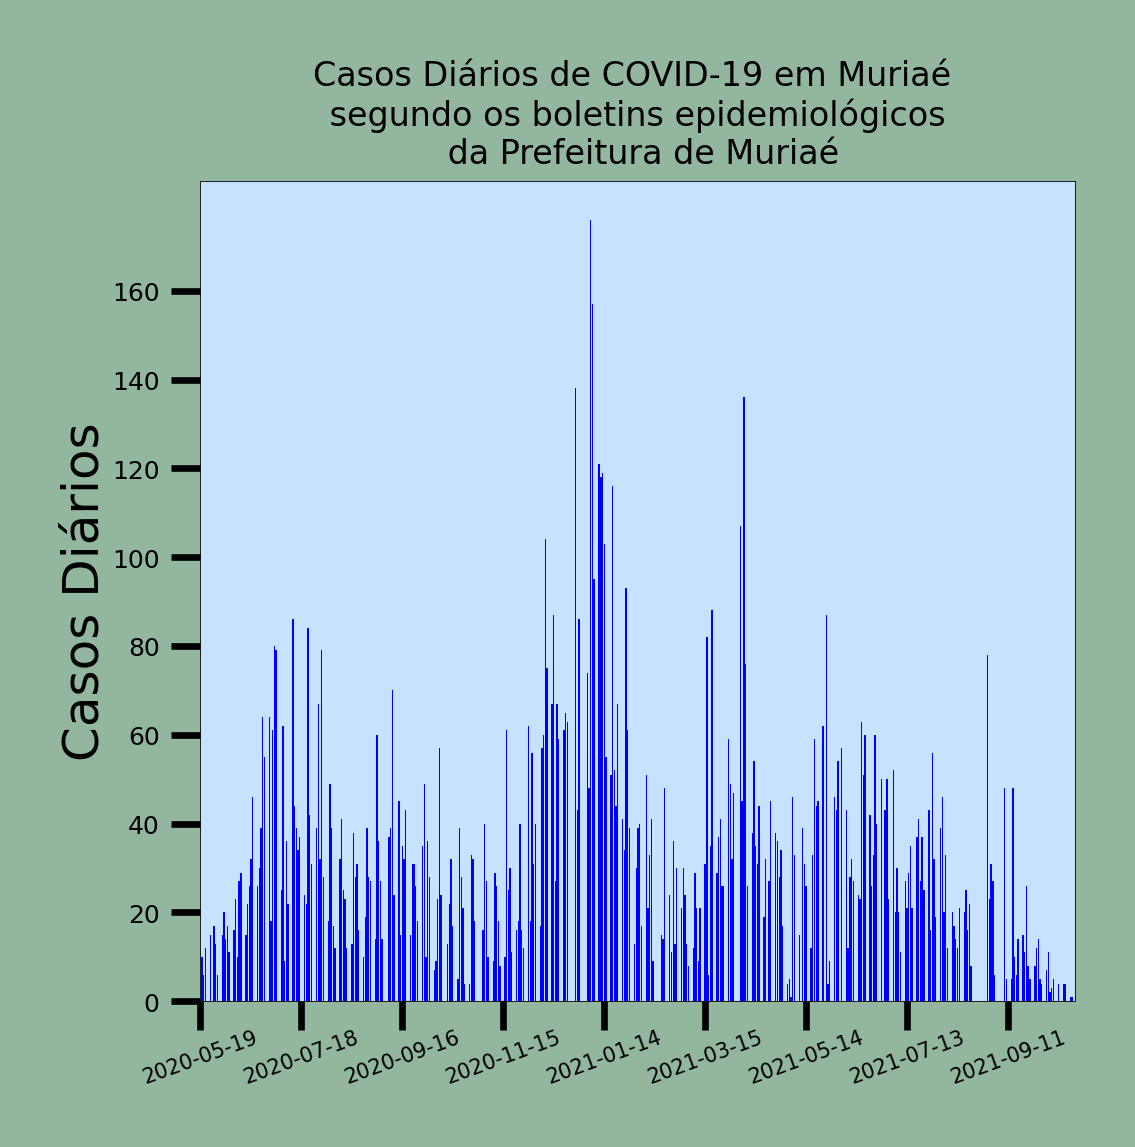

In [31]:
plotar_casos_diarios(save=True)

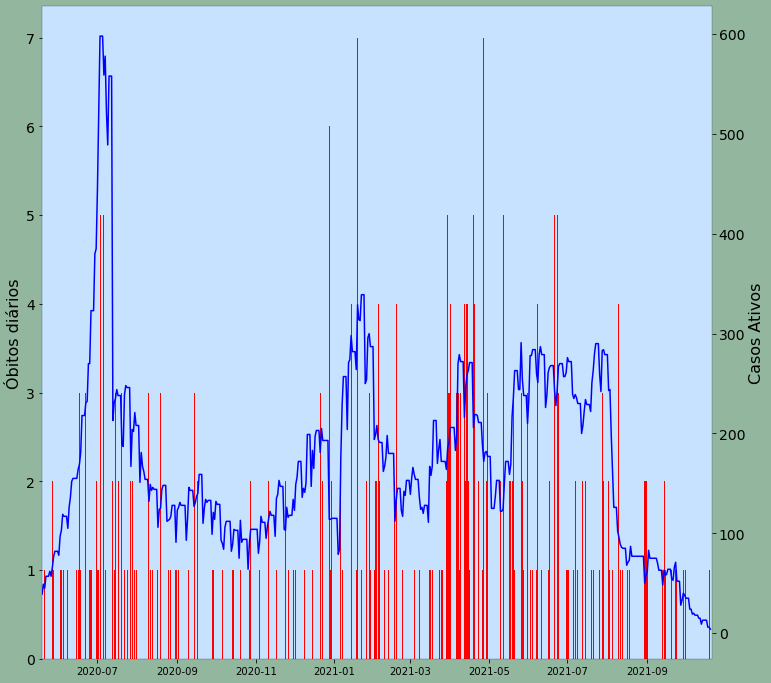

In [32]:
relacao_ativosObtos(save=True)